(1600, 1200, 3)


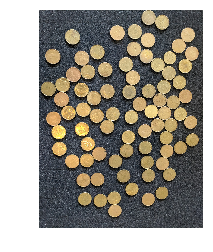

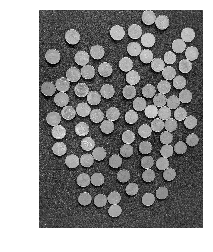

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from matplotlib.patches import Circle
import math
%matplotlib inline

im = plt.imread("img/coins1.jpg")

print(im.shape)

def plot(img,**kwargs):
    plt.figure()
    plt.imshow(img,interpolation="none",**kwargs)
    plt.axis('off')

bw_im = np.mean(im,axis=2)

plot(im)
plot(bw_im,**{'cmap':'gray'})

In [2]:
from src.functions import *

In [3]:
field_height = 3
field_width = 3

In [4]:
a = np.array([1,2,3])
print(np.tile(a,3))

[1 2 3 1 2 3 1 2 3]


In [5]:
def conv2d(f,g,N=1,k=1):
    if N==1:
        f = np.rollaxis(im,2,0)[np.newaxis,:,:,:].astype(int)
    N,C,H,W = f.shape
    field_height, field_width = g.shape
    
    h,w = g.shape

        
    x_pad = int(0.5*((W-1)*k-W+w))
    y_pad = int(0.5*((H-1)*k-H+w))
    
    X_col = im2col_indices(f, field_height, field_width, padding=x_pad, stride=1)
    g = np.tile(g.flatten(),C)
    return g.dot(X_col).reshape((H,W))/255/C

def conv2d_loop(f,g,k=1,**kwargs):
    w,h = g.shape
    W,H = f.shape
    
    g = np.rot90(g,2)
    
    x_pad = int(0.5*((W-1)*k-W+w))
    y_pad = int(0.5*((H-1)*k-H+w))
     
    #g = np.repeat(g[:,:,np.newaxis],3,2)
    
    f_pad = np.pad(f,((y_pad,y_pad),(x_pad,x_pad)),mode='constant')
    
    new_im = []
    for m in range(int(f_pad.shape[0]-w)+1):
        for n in range(int(f_pad.shape[1]-h+1)):
            fg = np.multiply(f_pad[m:m+w,n:n+h],g)
            sum_fg = np.sum(fg,axis=(0,1))
            new_im.append(sum_fg)
            
    return np.array(new_im).reshape(W,H)
    

In [6]:
bw_im.shape

(1600, 1200)

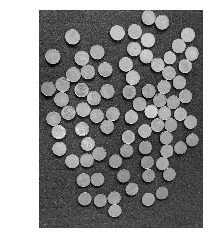

In [7]:
plot(conv2d(im,np.ones((3,3))),**{'cmap':'gray'})

In [8]:
def gradientG(t,w,sigma):
    return (-t/(2*math.pi*sigma**4))*math.e**(-1*(t**2+w**2)/(2*sigma**2))
    
def DOG(h,w,sigma,grad_type='x'):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for j in range(w):
        for i in range(h):
            if grad_type=='x':
                G.append(gradientG((i-n),(j-n),sigma))
            elif grad_type=='y':
                G.append(gradientG((j-n),(i-n),sigma))
    
    return np.array(G).reshape(w,h)

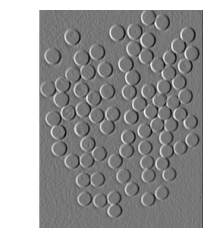

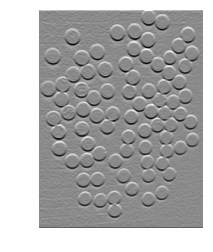

In [9]:
gx =  DOG(21,21,21/3,'x')
gy =  DOG(21,21,21/3,'y')
        
plot(conv2d_loop(bw_im,gx),**{'cmap':'gray'})
plot(conv2d_loop(bw_im,gy),**{'cmap':'gray'})

In [197]:
import numpy.ma as ma

def peakDetection(x0,n_pad,S_pad):

    n0 = np.array(([n_pad[0][x0],n_pad[1][x0]]))

    q0 = x0 + n0*1/(2*math.sin(math.pi/8))
    q1 = x0 - n0*1/(2*math.sin(math.pi/8))

    k,l=np.rint(q0).astype(int).tolist()
    k1,l1=np.rint(q1).astype(int).tolist()
    
    return (S_pad[x0[0],x0[1]]>S_pad[k,l])|(S_pad[x0[0],x0[1]]>S_pad[k1,l1])


class canny:
    def __init__(self,im,th=0.1,gsize=(3,3),sigma=1):
        self.im = im
        self.th = th
        self.gsize = gsize
        self.sigma=sigma
        self.compute_gradients()
        self.non_max_sup()
        self.pts = np.argwhere(self.S)
    
    def compute_gradients(self):
        th = self.th
        sigma = self.sigma
        M = self.im
        h,w = self.gsize
        gx =  DOG(h,w,sigma,'x')
        gy =  DOG(h,w,sigma,'y')

        grad_x = conv2d_loop(M,gx)
        grad_y = conv2d_loop(M,gy)

        R = (grad_x,grad_y)

        S = np.sqrt(grad_x**2+grad_y**2)
        mask = ma.masked_where(S > th*S.max(), S).mask
        
        n = mask*np.divide(R,S,out=np.zeros_like(R),where=S!=0)
        
        plot(S,**{'cmap':'gray'})
        
        self.R = R*mask
        self.S = S*mask
        self.n = n*mask
        self.mask = mask
    
    def non_max_sup(self):
        S = self.S
        H,W = S.shape
        h,w = self.gsize
        n = self.n
        k=1
        x_pad = int(0.5*((H-1)*k-H+h))
        y_pad = int(0.5*((W-1)*k-W+w))

        S_pad = np.pad(S,((x_pad,x_pad),(y_pad,y_pad)),mode='constant')
        nx_pad = np.pad(n[0],((x_pad,x_pad),(y_pad,y_pad)),mode='constant')
        ny_pad = np.pad(n[1],((x_pad,x_pad),(y_pad,y_pad)),mode='constant')

        peaks = np.zeros_like(S)
        count=0
        for i in range(H):
            for j in range(W):
                x0 = (i+int(h/2-1),j+int(w/2-1))

                if peakDetection(x0,(nx_pad,ny_pad),S_pad)==True:
                    peaks[i,j]=1

                count+=1  
        print("Sanity check: {}".format(count==H*W))
        peaks[-20,:]=0
        peaks[:,-20:]=0
        peaks[:20,:]=0
        peaks[:,:20]=0
        plot(peaks,**{'cmap':'gray'})
        
        self.mask = peaks
        self.R = self.R*peaks
        self.S = self.S*peaks
        self.n = self.n*peaks


In [11]:
def plot_circle(circles):
    
    plt.imshow(im)

    circle = Circle((circles[-1][0]),radius=circles[-1][1])
    ax = plt.gca()
    ax.add_patch(circle)
    plt.axis('scaled')
    plt.show()

canny1 = canny(bw_im/255,th=0.5,gsize=(11,11),sigma=11/3)
im_bw = canny1.mask
normals = canny1.R
mask = canny1.mask
n = np.divide(normals[1],normals[0],out=np.zeros_like(normals[1]),where=normals[0]!=0)*mask
pts = np.nonzero(mask)
l = np.array((n[np.nonzero(mask)],np.ones(n[np.nonzero(mask)].shape[0]),pts[1]-n[np.nonzero(mask)]*pts[0])).T

In [12]:
'''
s: smallest number of points required
N: number of iterations required
d: threshold to identify a point that fits well
T: number of nearby points required
'''
def RANSAC(p,normals,d=25,s=100,N=1000,T=200):
    l=normals
    center = []
    center_bin = []
    circles = []
    k=0
    ins=s
    for i in range(N):

        ind1,ind2 = np.random.choice(range(p[0].shape[0]),2)
        interect = np.cross(l[ind1],l[ind2])

        cart = np.divide(interect[:2],interect[2],out=np.zeros_like(interect[:2]),where=interect[2]!=0)

        logic = (cart[0]>p[0].min()) & (cart[1]>p[1].min()) & (cart[0]<p[0].max()) & (cart[1]<p[1].max())

        if logic==True:
            center.append(interect)
            center_bin.append(cart)

            for r in np.arange(20,150,10):
                
                ri_sq = np.sum((np.array(p).T - center_bin[k])**2,axis=1)
                di = np.abs(ri_sq - r**2)

                ins = np.sum(di<d**2)


                if ins>s:
                    circles.append([center_bin[k],r,ins,ri_sq < (r+2*d)**2])
                    s = ins
                    inliers = di<d**2
                    outliers = ri_sq < (r-d)**2

                    outs = np.sum(outliers)

                    if ins>T: break

                if ins>T: break
            if ins>T: break

                
            k+=1
    
    return circles,inliers,outliers
                

In [233]:
'''
s: smallest number of points required
N: number of iterations required
d: threshold to identify a point that fits well
T: number of nearby points required
'''
def get_proposals(p,normals,d=25,s=100,N=1000,T=200):
    
    p = np.array(p)
    
    a=np.divide(normals[1],normals[0],out=np.zeros_like(normals[1]),where=normals[0]!=0)[p.tolist()]
    
    b = p[1,:] - p[0,:]*a
    
    l = np.array((a,np.ones(a.shape[0]),b)).T #H*W
    
    center = []
    center_bin = []
    circles = []
    k=0
    ins=s
    for i in range(N):

        ind1,ind2 = np.random.choice(range(p[0].shape[0]),2)
        interect = np.cross(l[ind1],l[ind2])

        cart = np.divide(interect[:2],interect[2],out=np.zeros_like(interect[:2]),where=interect[2]!=0)
        

        logic = (cart[0]>p[0,:].min()) & (cart[1]>p[1,:].min()) & (cart[0]<p[0,:].max()) & (cart[1]<p[1,:].max())

        if logic==True:
            center_bin.append(cart)
            
            for r in np.arange(20,150,10):

                ri_sq = np.sum((p.T - center_bin[k])**2,axis=1)
                di = np.abs(ri_sq - r**2)

                ins = np.sum(di<d**2)


                if ins>s:
                    circles.append([center_bin[k],r,ins,ri_sq < (r+2*d)**2])
                    s = ins
                    inliers = di<d**2
                    outliers = ri_sq < (r-d)**2

                    outs = np.sum(outliers)

                    if ins>T: break

                if ins>T: break
            if ins>T: break
            k+=1
    
    return circles
       

Sanity check: True


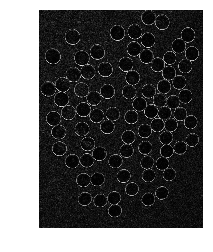

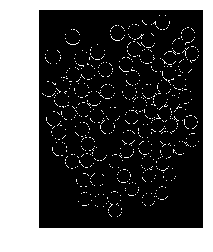

In [113]:
canny1 = canny(bw_im/255,th=0.4,gsize=(7,7),sigma=7/3)

In [183]:
normals = canny1.n
p = np.array(canny1.pts)
a=np.divide(normals[1],normals[0],out=np.zeros_like(normals[1]),where=normals[0]!=0)


In [230]:
np.array(p)

array([[   0,    0,    0, ..., 1599, 1599, 1599],
       [  56,   57,   58, ..., 1162, 1163, 1164]])

In [234]:
circles = get_proposals(canny1.pts,canny1.n)

In [235]:
circles

[[array([ 314.72023463, 1069.1656198 ]),
  20,
  385,
  array([False, False, False, ..., False, False, False])]]

In [ ]:
canny1 = canny(bw_im/255,th=0.4,gsize=(21,21),sigma=21/3)

In [ ]:
len(np.nonzero(canny1.n[:,canny1.pts]))

In [ ]:
l = np.array((n[np.nonzero(mask)],np.ones(n[np.nonzero(mask)].shape[0]),pts[1]-n[np.nonzero(mask)]*pts[0])).T #H*W


In [236]:
def get_points_from_cond(p,cond,color):   
    aa = p[0][cond]
    bb = p[1][cond]
    plt.scatter(aa,bb,s=1,color=color)
    pass


In [237]:
def plot_RANSAC(p,circles,inliers,outliers,d=15,pos=1):

    circle = circles[-1*pos]
    center = circle[0]
    r = circle[1]

    di = (np.array(p) - center[:,np.newaxis])
    cond = np.sum(di**2,axis=0) - r**2 < d
    get_points_from_cond(p,inliers,'red')
    get_points_from_cond(p,outliers,'blue')

    ax = plt.gca()
    ax.add_patch(Circle((center[0],center[1]),radius=r,color='red',fill=False,**{'alpha':0.5}))
    plt.axis('scaled')
    plt.show()
   


In [238]:
def GSVD(A,B):
    assert np.all(np.linalg.eigvals(B)>0)
    #B=GG.T
    G = np.linalg.cholesky(B)
    G_inv = np.linalg.inv(G)
    C = G_inv.dot(A).dot(G_inv.T)
    Q,R = np.linalg.qr(C)
    eigvals = Q.T.dot(C).dot(Q)
    X = G_inv.T.dot(Q)
    print("check identity = {}".format(np.sum(X.T.dot(B).X)))
    return X
    
    
    
    

In [239]:
from scipy.linalg import eigh
def IWLS(circles,p,t,sigmaGM=10,check=0):
 
    x0 = circles[-1][0]
    initr = circles[-1][1]

    B,C = -2*x0
    D = -(4*initr**2-B**2-C**2)/4

    xk = np.array(p)
    pts = xk

    A= np.array([1,B,C,D])

    z = np.sum(pts**2,axis=0)

    Z = np.vstack((z,pts,np.ones_like(z))).T
    
    ek = Z.dot(A)
    
    num = (2*sigmaGM**2)
    den = (sigmaGM**2+ek**2)**2
    w = np.divide(num,den,out=np.zeros_like(den),where=den!=0)


    for i in range(1000):
        
        M =(Z*w[:,np.newaxis]).T.dot(Z)

        U,S,V = np.linalg.svd(M)

        d = V[-1,:] - A
        
        if (i>10)&(d.T.dot(d)<1e-10):
            A = V[-1,:]
            break
               
        A = V[-1,:]
        
        ek = Z.dot(A)
        
        num = (2*sigmaGM**2)
        den = (sigmaGM**2+ek**2)**2
        w = np.divide(num,den,out=np.zeros_like(den),where=den!=0)
             
        influence = ek*w
        
        '''(beg)Leverage computation'''

        m = np.sum(w[np.newaxis,:]*xk,axis=0)/(np.sum(w)+1e-10)

        leverage = np.abs(np.sum(t*(xk-m[np.newaxis,:]),axis=0)*influence)
        
        w[np.divide(leverage,leverage.max(),out=np.zeros_like(leverage),where=leverage.max()!=0)>0.7]=0
        '''Leverage computation (end)'''      

    a = -A[1]/(2*(A[0]))
    b = -A[2]/(2*(A[0]))
    R = np.sqrt((A[1]**2+A[2]**2-4*A[0]*A[3])/(4*A[0]**2))
    
    if check==1:
        print("AtMA>0: {}".format(A.T.dot(M).dot(A)))
        print("AtNA>0: {}".format(A.T.dot(N).dot(A)))
        print("SVD: {}".format(np.allclose(M,U.dot(np.diag(S)).dot(V))))
        print(a,b,R)
    
    return [a,b,R],w

In [240]:
def plot_IWLS(p,param1,cond,inliers,leverage,w,d):
    
    aa = p[0][cond]
    bb = p[1][cond]

    a,b,R = param1
    
    plt.scatter(aa,bb,color='blue')
    plt.scatter(aa[inliers],bb[inliers],color='red')
    plt.scatter(aa[leverage/leverage.max()>.5],bb[leverage/leverage.max()>.5],color='green')
    circle = Circle((a,b),radius=R,fill=False,**{"alpha":.5,'color':'red'})
    ax = plt.gca()
    ax.add_patch(circle)
    plt.axis('scaled')
    


In [248]:
%timeit
import time
import pylab as pl
from IPython import display

mask = canny1.mask
normals = canny1.R


p =canny1.pts

d=25
check=False
count1=0

pts = np.nonzero(mask) #(2,H*W)
nx = np.array(normals[0][np.nonzero(mask)]) #HxW
ny = np.array(normals[1][np.nonzero(mask)]) #HxW
n = np.divide(normals[1],normals[0],out=np.zeros_like(normals[1]),where=normals[0]!=0)*mask #HxW
l = np.array((n[np.nonzero(mask)],np.ones(n[np.nonzero(mask)].shape[0]),pts[1]-n[np.nonzero(mask)]*pts[0])).T #H*W

plt.show()

for i in range(50):
       
    circles,inliers,outliers = RANSAC(pts,l,d=d,s=100,T=300)
    
    cond = inliers | outliers
    aa = pts[0][cond]
    bb = pts[1][cond] 
    tx = - ny[cond]
    ty =  nx[cond]
    t = np.array([tx,ty])
    sig = 10

    param1,w = IWLS(circles,(aa,bb),(tx,ty),sigmaGM=sig,check=0)
          
    a,b,R=param1
    
    ek=np.sum((np.array([aa,bb]).T - np.array((a,b)))**2,axis=1)-R**2

    influence = np.sum(ek*w)
    
    xks = np.array((pts[0][cond],pts[1][cond]))

    m = np.sum(w*xks,axis=0)/np.sum(w)
    
    leverage = np.abs(np.sum(t*(xks-m),axis=0)*influence)
    
    stdn_leverage=np.divide(leverage,leverage.max(),out=np.zeros_like(leverage),where=leverage.max()!=0)
    count,edges = np.histogram(stdn_leverage,2)
    
    new_inliers = ek<15**2   
    


    plt.ion()
    if (np.mean(leverage)<.5)&(np.sum(new_inliers)>300)&(R!=0):

        new_mask = np.sum((np.array([pts[0],pts[1]]).T - np.array((a,b)))**2,axis=1) > (R+10)**2 #H*W      
        
        count1+=1
        
        plt.imshow(canny1.S,**{'cmap':'gray'})
        
        circle = Circle((b,a),radius=R,color='red',fill=False,**{"linewidth":2})
        ax = plt.gca()
        ax.add_patch(circle)
        plt.axis('scaled')

        plt.draw()
              
        if check==True:
            plot_RANSAC(p,circles,inliers,outliers,d=d,pos=1)

            plot_IWLS(p,param1,cond,new_inliers,leverage,w,d=10)

            plt.figure()

            plt.hist(stdn_leverage,bins='auto')
            plt.figure()
            
        if count[-1]==0:
            levg_idx = 0
        else:
            levg_idx = count[0]/count[-1]
        
        '''
        print("leverage: {}".format(np.mean(stdn_leverage)))       
        print('leverage ratio: {}'.format(levg_idx))
        print('inliers count: {}'.format(np.sum(new_inliers)))
        print('Current count: {}'.format(count1))
        print('R: {}'.format(R))
        print('Crcle center: {}'.format((a,b)))
        '''
        print('Current count: {}'.format(count1))
        print('Iteration: {}'.format(i))

        
        pts= (pts[0]*new_mask,pts[1]*new_mask)
 
        nx = nx*new_mask
        ny = nx*new_mask
        
        l *= new_mask[:,np.newaxis]
        
        pl.plot()
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(1.0)

print("Total detected: {}".format(count1))


Total detected: 0


In [241]:
import time
import pylab as pl
from IPython import display

def RobustFittingCircles(canny1,N=10,check=False,d=25,s=100,T=300,sigmaGM=100,muLeverage=0.5,
                        num_inliers=300):
    mask = canny1.mask
    normals = canny1.R
    p =np.nonzero(mask)


    count1=0

    pts = np.nonzero(mask) #(2,H*W)
    nx = np.array(normals[0][np.nonzero(mask)]) #HxW
    ny = np.array(normals[1][np.nonzero(mask)]) #HxW
    n = np.divide(normals[1],normals[0],out=np.zeros_like(normals[1]),where=normals[0]!=0)*mask #HxW
    l = np.array((n[np.nonzero(mask)],np.ones(n[np.nonzero(mask)].shape[0]),pts[1]-n[np.nonzero(mask)]*pts[0])).T #H*W

    #plt.show()

    for i in range(N):

        circles,inliers,outliers = RANSAC(pts,l,d=d,s=s,T=T)

        cond = inliers | outliers
        aa = pts[0][cond]
        bb = pts[1][cond] 
        tx = - nx[cond]
        ty =  ny[cond]
        t = np.array([tx,ty])


        param1,w = IWLS(circles,(aa,bb),(tx,ty),sigmaGM=sigmaGM,check=0)

        a,b,R=param1

        ek=np.sum((np.array([aa,bb]).T - np.array((a,b)))**2,axis=1)-R**2

        influence = np.sum(ek*w)

        xks = np.array((pts[0][cond],pts[1][cond]))

        m = np.sum(w*xks,axis=0)/np.sum(w)

        leverage = np.abs(np.sum(t*(xks-m),axis=0)*influence)

        stdn_leverage=np.divide(leverage,leverage.max(),out=np.zeros_like(leverage),where=leverage.max()!=0)
        count,edges = np.histogram(stdn_leverage,2)

        new_inliers = ek<20**2   

        plt.ion()
        if (np.mean(leverage)<muLeverage)&(np.sum(new_inliers)>num_inliers)&(R!=0):

            new_mask = np.sum((np.array([pts[0],pts[1]]).T - np.array((a,b)))**2,axis=1) > (R+20)**2 #H*W      

            count1+=1

            plt.imshow(canny1.S,**{'cmap':'gray'})

            circle = Circle((b,a),radius=R,color='red',fill=False,**{"linewidth":2})
            ax = plt.gca()
            ax.add_patch(circle)
            plt.axis('scaled')

            plt.draw()

            if check==True:
                plot_RANSAC(pts,circles,inliers,outliers,d=d,pos=1)

                plot_IWLS(pts,param1,cond,new_inliers,leverage,w,d=10)

                plt.figure()

                plt.hist(stdn_leverage,bins='auto')
                plt.figure()

            if count[-1]==0:
                levg_idx = 0
            else:
                levg_idx = count[0]/count[-1]

            '''
            print("leverage: {}".format(np.mean(stdn_leverage)))       
            print('leverage ratio: {}'.format(levg_idx))
            print('inliers count: {}'.format(np.sum(new_inliers)))
            print('Current count: {}'.format(count1))
            print('R: {}'.format(R))
            print('Crcle center: {}'.format((a,b)))
            '''
            print('Current count: {}'.format(count1))
            print('Iteration: {}'.format(i))


            pts= np.nonzero(pts[0]*new_mask),np.nonzero(pts[1]*new_mask)
            #print(np.nonzero(pts[0])[0].shape)
            

            nx = np.array(np.nonzero(nx*new_mask))
            ny = np.array(np.nonzero(ny*new_mask))

            l *= new_mask[:,np.newaxis]
            l = np.array(l)
            
            plt.scatter(pts[1],pts[0],s=0.1,color='blue')

            pl.plot()
            display.clear_output(wait=True)
            display.display(pl.gcf())          
            time.sleep(1.0)
    plt.figure()
    plt.scatter(pts[1],-1*pts[0],s=0.1,color='blue')
    plt.plot()
    print("Total detected: {}".format(count1))
    pass


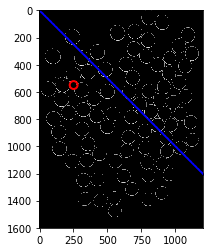

AttributeError: 'tuple' object has no attribute 'shape'

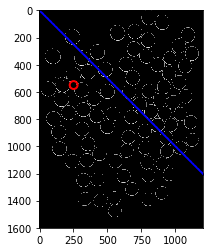

In [242]:
%timeit
RobustFittingCircles(canny1,N=50,check=False,d=30,s=100,T=500,sigmaGM=100,muLeverage=0.6,
                        num_inliers=300)

In [ ]:
canny1 = canny(bw_im/255,th=0.6,gsize=(21,21),sigma=21/3)